Import all required libraries

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import RandomFlip, RandomRotation
from pathlib import Path

Load Data and split it into training and testing data.

In [81]:
path = Path('/Users/sonil/Desktop/Image Classifier/cats_projekat/')
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(path,shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE,validation_split=0.2, subset='training', seed=42)
validation_dataset = image_dataset_from_directory(path, shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE,validation_split=0.2,subset='validation',seed=42)

Found 2149 files belonging to 3 classes.
Using 1720 files for training.
Found 2149 files belonging to 3 classes.
Using 429 files for validation.


Checking distribution of images available for each image category.

In [82]:
cheetah_path = Path('/Users/sonil/Desktop/Image Classifier/cats_projekat/cheetahs')
jaguar_path = Path('/Users/sonil/Desktop/Image Classifier/cats_projekat/jaguars')
leopard_path = Path('/Users/sonil/Desktop/Image Classifier/cats_projekat/leopards')

# Count all files (not directories) in the folders
file_count = len([f for f in cheetah_path.iterdir() if f.is_file()])
print(f"Number of files in {cheetah_path.name}: {file_count}")
file_count = len([f for f in jaguar_path.iterdir() if f.is_file()])
print(f"Number of files in {jaguar_path.name}: {file_count}")
file_count = len([f for f in leopard_path.iterdir() if f.is_file()])
print(f"Number of files in {leopard_path.name}: {file_count}")

Number of files in cheetahs: 717
Number of files in jaguars: 704
Number of files in leopards: 729


A look at what the dataset looks like.


In [83]:
total = 0
for batch in train_dataset:
    total += batch[0].shape[0]
print(total)  # This will print 1540

1720


In [84]:
class_names = train_dataset.class_names
print(class_names)

['cheetahs', 'jaguars', 'leopards']


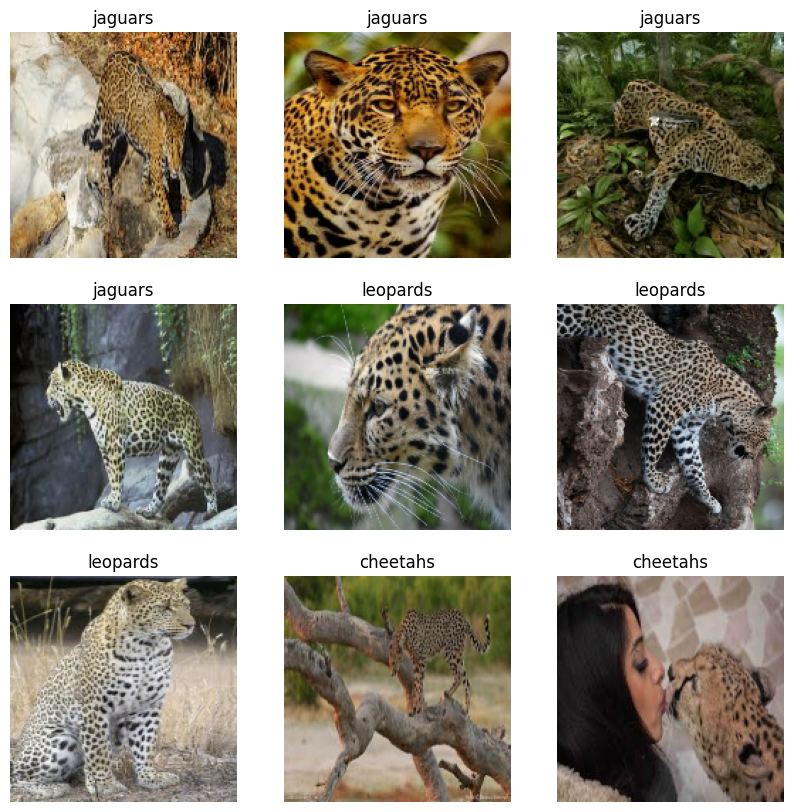

In [85]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Prefetching to improve efficiency by overlapping preprocessing and training on different batches.


In [86]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [87]:
# One hot encoding

NUM_CLASSES = 3  # cheetahs, jaguars, leopards

def one_hot_encode(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_dataset = train_dataset.map(one_hot_encode)
validation_dataset = validation_dataset.map(one_hot_encode)

Defining data augmentation, normalization, and prefetching Pipeline

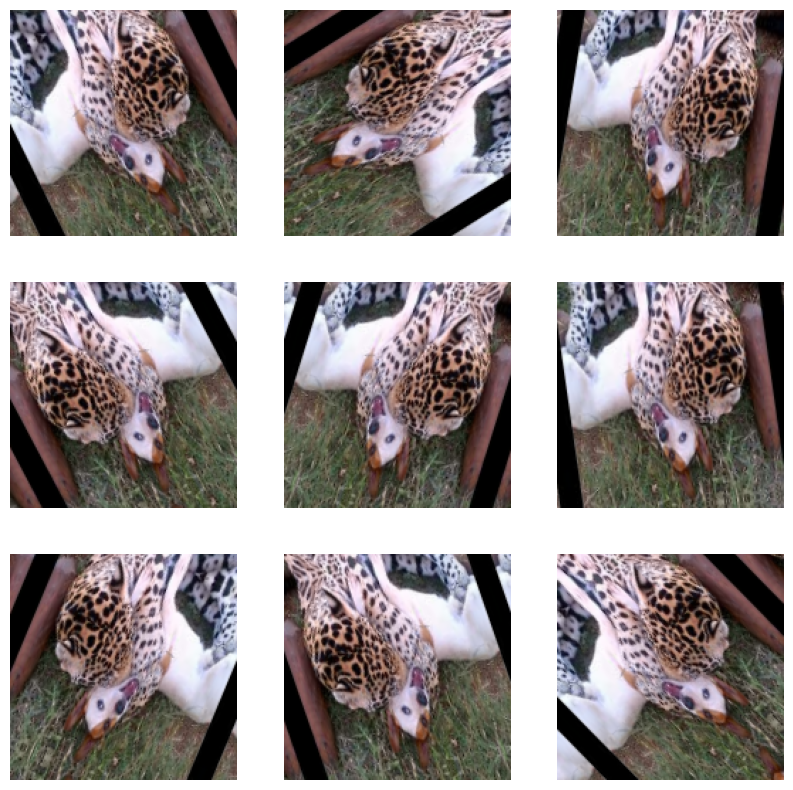

In [88]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal"))
    data_augmentation.add(RandomRotation(0.2))   
    return data_augmentation
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [89]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    return data_augmentation

Time to bring in Mobilenet.

In [90]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [91]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model_path="imagenet_base_model/with_top_mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_160.h5"
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [92]:
base_model.summary()


Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_20[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

Let us look at the last two layers.

In [93]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d_7
predictions


Check Output shape

In [94]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


(32,1000) makes sense since 32 is batch size and Mobilenet originally has 1000 classes.

In [95]:
def bigcat_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    
    #to make sure the model expects RGB images as input.
    input_shape = image_shape + (3,)

    #load mobilenet_v2 as base feature extractor without including final classification layers.
    base_model_path="imagenet_base_model/without_top_mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_160_no_top.h5"
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, 
                                                   weights='imagenet')
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # add the new classification layers
    # use global avg pooling to summarize the info in each channel
    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tf.keras.layers.Dropout(0.2)(x)
        
    # use a prediction layer with threee neurons (three classes)
    outputs = tf.keras.layers.Dense(3)(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [96]:
model2 = bigcat_model(IMG_SIZE)


In [97]:
model2.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_9 (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_4 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_4 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Configure the model before training. (which optimizer, loss function and metric to use.)

In [98]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Start training and track the progress.

In [99]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 205ms/step - accuracy: 0.4446 - loss: 1.1609 - val_accuracy: 0.6923 - val_loss: 0.6861
Epoch 2/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - accuracy: 0.6947 - loss: 0.7160 - val_accuracy: 0.7343 - val_loss: 0.6455
Epoch 3/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 209ms/step - accuracy: 0.7180 - loss: 0.6476 - val_accuracy: 0.7436 - val_loss: 0.6307
Epoch 4/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 197ms/step - accuracy: 0.7347 - loss: 0.6347 - val_accuracy: 0.7483 - val_loss: 0.6062
Epoch 5/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 192ms/step - accuracy: 0.7472 - loss: 0.5850 - val_accuracy: 0.7622 - val_loss: 0.5815


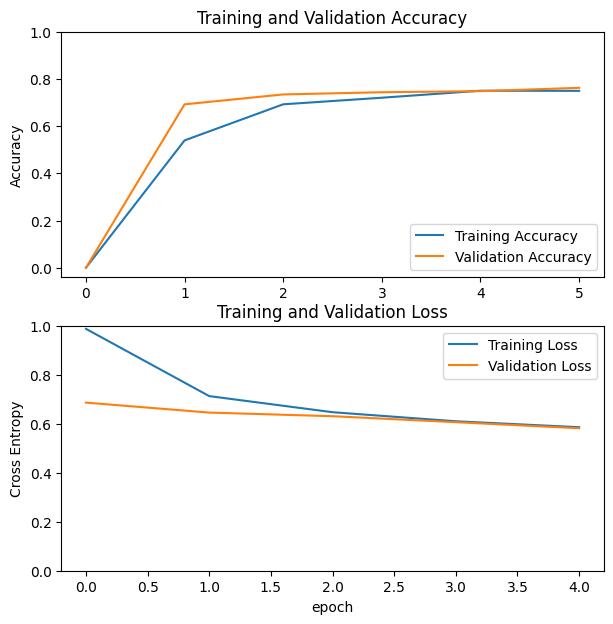

In [100]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(7,7))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Check on test data 

In [101]:
path1 = Path('/Users/sonil/Desktop/Image Classifier/a/')

IMG_SIZE = (160, 160)
test_dataset = image_dataset_from_directory(path1, shuffle=False, image_size=IMG_SIZE,  seed=42)
class_names2 = test_dataset.class_names
print(class_names2)

# One hot encoding of test data
NUM_CLASSES = 3  # cheetahs, jaguars, leopards

def one_hot_encode(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

test_dataset = test_dataset.map(one_hot_encode)
from pathlib import Path
from PIL import Image

test_dir = path1 
for class_dir in test_dir.iterdir():
    if class_dir.is_dir():
        for img_path in class_dir.iterdir():
            try:
                img = Image.open(img_path)
                img.verify()  # Verify that it is, in fact, an image
            except Exception as e:
                print(f"Removing corrupted file: {img_path}")
                img_path.unlink()  # Remove the file
import imghdr
from pathlib import Path

test_dir = path1

for class_dir in test_dir.iterdir():
    if class_dir.is_dir():
        for img_path in class_dir.iterdir():
            img_type = imghdr.what(img_path)
            if img_type not in ['jpeg', 'png', 'bmp', 'gif']:
                print(f"Removing non-image or unsupported file: {img_path}")
                img_path.unlink()
results = model2.evaluate(test_dataset)
print("Test Accuracy :",results[1])

Found 483 files belonging to 3 classes.
['cheetahs', 'jaguars', 'leopards']
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step - accuracy: 0.9110 - loss: 0.3162
Test Accuracy : 0.850931704044342


**85.09% test accuracy**. 
Not bad.

Let's see if we can improve this by fine tuning the top layers 

In [102]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 130

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = None
# Define a loss function
loss_function= tf.keras.losses.CategoricalCrossentropy(from_logits=True),
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate*0.1)# 0.001
# Use accuracy as evaluation metric
metrics=['accuracy']

### END CODE HERE

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)    

Number of layers in the base model:  156


In [103]:

fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step - accuracy: 0.7705 - loss: 0.5372 - val_accuracy: 0.7669 - val_loss: 0.5839
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 200ms/step - accuracy: 0.7752 - loss: 0.5401 - val_accuracy: 0.7669 - val_loss: 0.5829
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step - accuracy: 0.7694 - loss: 0.5337 - val_accuracy: 0.7646 - val_loss: 0.5790
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step - accuracy: 0.7724 - loss: 0.5477 - val_accuracy: 0.7622 - val_loss: 0.5834
Epoch 9/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step - accuracy: 0.7718 - loss: 0.5247 - val_accuracy: 0.7599 - val_loss: 0.5807
Epoch 10/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 206ms/step - accuracy: 0.7623 - loss: 0.5468 - val_accuracy: 0.7692 - val_loss: 0.5775


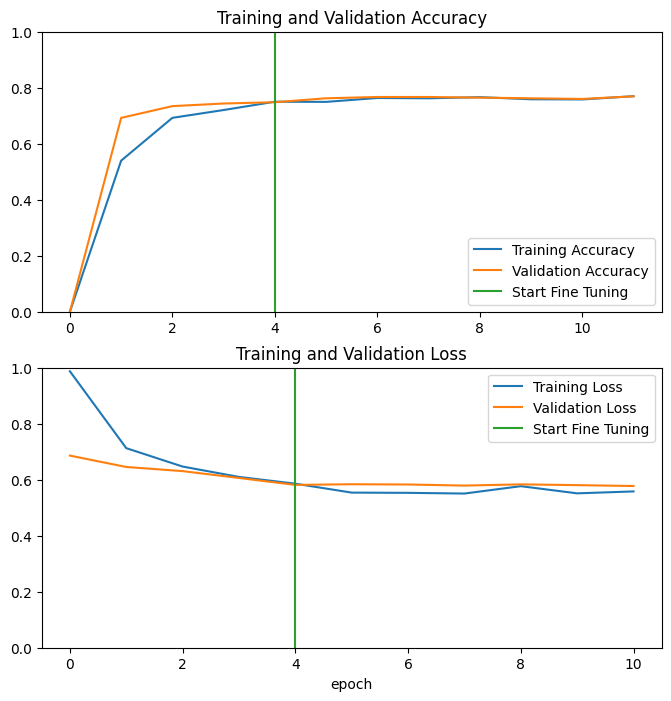

In [104]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [105]:
path1 = Path('/Users/sonil/Desktop/Image Classifier/a/')

IMG_SIZE = (160, 160)
test_dataset = image_dataset_from_directory(path1, shuffle=False, image_size=IMG_SIZE,  seed=42)
class_names2 = test_dataset.class_names
print(class_names2)

# One hot encoding of test data
NUM_CLASSES = 3  # cheetahs, jaguars, leopards

def one_hot_encode(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

test_dataset = test_dataset.map(one_hot_encode)
from pathlib import Path
from PIL import Image

test_dir = path1 
for class_dir in test_dir.iterdir():
    if class_dir.is_dir():
        for img_path in class_dir.iterdir():
            try:
                img = Image.open(img_path)
                img.verify()  # Verify that it is, in fact, an image
            except Exception as e:
                print(f"Removing corrupted file: {img_path}")
                img_path.unlink()  # Remove the file
import imghdr
from pathlib import Path

test_dir = path1

for class_dir in test_dir.iterdir():
    if class_dir.is_dir():
        for img_path in class_dir.iterdir():
            img_type = imghdr.what(img_path)
            if img_type not in ['jpeg', 'png', 'bmp', 'gif']:
                print(f"Removing non-image or unsupported file: {img_path}")
                img_path.unlink()
results = model2.evaluate(test_dataset)
print("Test Accuracy :",results[1])

Found 483 files belonging to 3 classes.
['cheetahs', 'jaguars', 'leopards']
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - accuracy: 0.9182 - loss: 0.2836
Test Accuracy : 0.8550724387168884


**85.51% Test Accuracy.**

Minor improvement of 0.4 percent through fine-tuning.